## Introduction: The Prisoner's Dilemma

The **Prisoner's Dilemma** is a classic problem in game theory that explores the conflict between individual interest and mutual benefit. In this game, two players must each independently choose between two actions: **cooperate** (C) or **defect** (D). The outcome for each player depends on the combination of their choices, as described by the payoff matrix below:

|   Choices | Opponent Cooperates | Opponent Defects |
|----------------|--------------------|------------------|
| **You Cooperate** | (3, 3)              | (0, 5)            |
| **You Defect**    | (5, 0)              | (1, 1)            |

- If both players cooperate, they each receive a moderate reward (3 points).
- If one defects while the other cooperates, the defector receives the highest reward (5 points) and the cooperator gets the lowest (0 points).
- If both defect, both receive a low payoff (1 point).

### Nash Equilibrium

A **Nash equilibrium** is a situation where no player can improve their outcome by unilaterally changing their strategy. In the one-shot Prisoner's Dilemma, the only Nash equilibrium is for both players to defect, since defecting always yields a higher or equal payoff regardless of the opponent's choice. However, this outcome is not optimal for either player, as mutual cooperation would yield a better reward for both.

### The Repeated Prisoner's Dilemma

The **Repeated Prisoner's Dilemma (RPD)** extends the game over multiple rounds between the same two players. This repetition fundamentally changes the strategic landscape: players can now condition their actions on the history of previous moves. This enables the emergence of more complex strategies, such as reciprocity (e.g., "Tit-for-Tat"), forgiveness, or retaliation, and makes sustained cooperation possible, even though defection is the rational choice in the single-shot game.


## Why Coevolution?

In the RPD, the success (fitness) of a strategy depends on the strategies present in the rest of the population. This means the fitness landscape is **dynamic** and **frequency-dependent**. As a result, **coevolutionary algorithms**, where individuals are evaluated relative to others in the population, are particularly effective for evolving robust strategies in this context.


## Genomic Representation

Each individual is represented by a **genome** of 19 real-valued genes:

- The first 3 genes encode the probability of cooperating in the first and second moves (depending on the opponent's first move).
- The remaining 16 genes encode the probability of cooperating for each possible combination of the last two moves by both players (i.e., the individual's response to every possible recent history).

Mathematically speaking, the space of possible strategies is $[0,1]^{19}$. We choose a real-valued representation for the strategies, as this is more expressive than a binary representation, and while less flexible than a tree representation, it will allow us to explore the space of possible strategies more efficiently, compare numerical values, and apply mutation and crossover more easily.


## Crossover and Mutation Operators

- **Blend Crossover:** The vector representation of the genome does not benefit from any positional bias, at the same time, given the bounded nature of the parameters, we risk having a distributional bias towards the interior of the parameter space. For this reason, we will use **blend crossover**, which is able to produce children that are outside of the convex hull of the parents. Then, we will cutoff values outside of the bounds.
- **Gaussian Mutation:** Each gene has a chance to be mutated by adding Gaussian noise, introducing continuous variation and enabling the discovery of new strategies.

These operators help maintain genetic diversity and facilitate effective search.


## Fitness Function

The fitness of each individual is determined by playing repeated games against a subset of other individuals in the population. The **average score per round** across these games is used as the individual's fitness. This ensures that fitness is always relative to the current population, reflecting the coevolutionary nature of the problem.


## Population Management

Our approach uses several population management techniques:

- **Age-Based Replacement:** We will use a strictly age-based replacement strategy: at each generation, we will **replace the entire population with the offspring**. This is due to the nature of the fitness function, which is based on comparing the agent with the entire population: comparing the offspring with the parents becomes an ill-posed problem, and would add unnecessary runtime. For this reason, fitness-based or hybrid replacement strategies are not suitable for this problem.
- **Rank Selection:** Individuals are selected for reproduction based on their fitness rank, favoring higher fitness but still allowing lower-fitness individuals a chance to reproduce. We chose this as opposed to fitness-proportional selection because it is less sensitive to noise in the fitness function, which is important in our case, as the fitness function is based on the average payoff of the agent after playing against the entire population. Additionally, in the case we choose to change the payoff matrix to allow for negative payoffs, fitness-proportional selection would be problematic.
- **Elitism:** The best-performing individuals are carried over unchanged to the next generation, preserving high-quality solutions. This will allow us to avoid losing the best strategy to mutation or crossover.

These choices help balance exploration and exploitation during evolution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rpd_utils as rpd

In [2]:
POPULATION_SIZE = 50
N_GENERATIONS = 5000
GENOME_LENGTH = rpd.GENOME_LENGTH

ROUNDS_PER_GAME = 100  # Number of rounds in a single RPD game
N_OPPONENTS_TO_PLAY = 10 # Each individual plays against N other individuals for fitness evaluation

ELITE_SIZE = 2          # Number of best individuals to carry to next generation
MUTATION_RATE = 0.1    # Probability of mutating a single gene
MUTATION_STRENGTH = 0.1 # Std deviation for Gaussian mutation
CROSSOVER_ALPHA = 0.2   # Crossover alpha for blend crossover

VERBOSITY = 500 # How often to print the status of the evolution process

In [3]:
population, avg_raw_score_history, best_raw_score_history, avg_fitness_history, population_diversity_history = rpd.run_evolution(POPULATION_SIZE, N_GENERATIONS, N_OPPONENTS_TO_PLAY, ROUNDS_PER_GAME, ELITE_SIZE, MUTATION_RATE, MUTATION_STRENGTH, CROSSOVER_ALPHA, VERBOSITY)

Generation 1/5000
Avg Raw Score: 2.27, Best Raw Score: 2.73
Avg Fitness: 2.27
Population Diversity: 1.80
Generation 501/5000
Avg Raw Score: 2.37, Best Raw Score: 2.47
Avg Fitness: 2.37
Population Diversity: 0.46
Generation 1001/5000
Avg Raw Score: 2.45, Best Raw Score: 2.48
Avg Fitness: 2.45
Population Diversity: 0.39
Generation 1501/5000
Avg Raw Score: 2.47, Best Raw Score: 2.50
Avg Fitness: 2.47
Population Diversity: 0.40
Generation 2001/5000
Avg Raw Score: 2.44, Best Raw Score: 2.50
Avg Fitness: 2.44
Population Diversity: 0.44
Generation 2501/5000
Avg Raw Score: 2.91, Best Raw Score: 2.94
Avg Fitness: 2.91
Population Diversity: 0.34
Generation 3001/5000
Avg Raw Score: 2.46, Best Raw Score: 2.49
Avg Fitness: 2.46
Population Diversity: 0.37
Generation 3501/5000
Avg Raw Score: 2.46, Best Raw Score: 2.50
Avg Fitness: 2.46
Population Diversity: 0.50
Generation 4001/5000
Avg Raw Score: 2.43, Best Raw Score: 2.48
Avg Fitness: 2.43
Population Diversity: 0.45
Generation 4501/5000
Avg Raw Sco

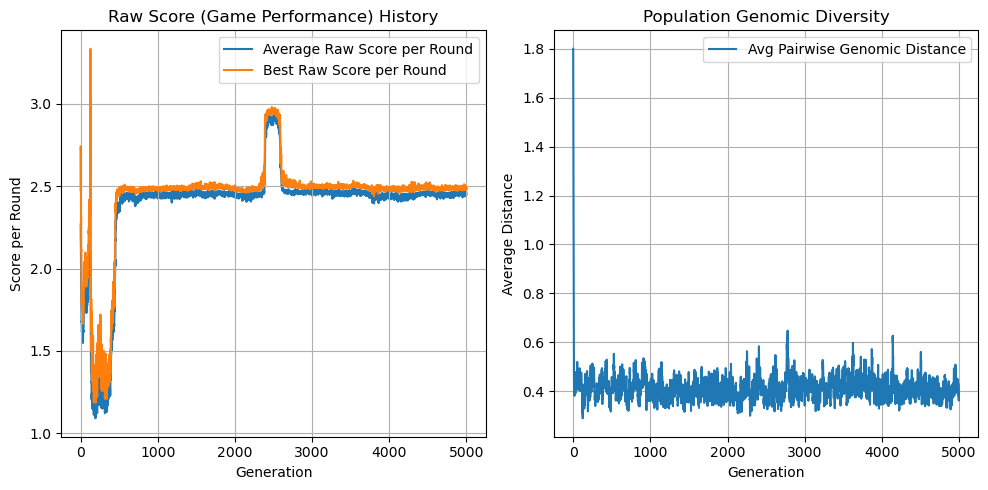

In [4]:
def plot_population(avg_raw_score_history, best_raw_score_history, population_diversity_history, dot_frequency = None):
    # --- Plotting Results ---
    plt.figure(figsize=(10, 5))

    # Plot 1: Fitness History (Raw Score)
    plt.subplot(1, 2, 1)
    plt.plot(avg_raw_score_history, label="Average Raw Score per Round", zorder=1)
    plt.plot(best_raw_score_history, label="Best Raw Score per Round", zorder=2)
    if dot_frequency:
        for i in range(dot_frequency, len(avg_raw_score_history), dot_frequency):
            plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(x=dot_frequency, color='gray', linestyle='--', alpha=0.5, label="Migration")
    plt.xlabel("Generation")
    plt.ylabel("Score per Round")
    plt.title("Raw Score (Game Performance) History")
    plt.legend()
    plt.grid(True)
    

    # Plot 2: Population Diversity
    plt.subplot(1, 2, 2)
    plt.plot(population_diversity_history, label="Avg Pairwise Genomic Distance")
    if dot_frequency:
        for i in range(dot_frequency, len(avg_raw_score_history), dot_frequency):
            plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(x=dot_frequency, color='gray', linestyle='--', alpha=0.5, label="Migration")
    plt.xlabel("Generation")
    plt.ylabel("Average Distance")
    plt.title("Population Genomic Diversity")
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.show()

plot_population(avg_raw_score_history, best_raw_score_history, population_diversity_history)

In [5]:
def analyse_evolved_strategy(population):
    # --- Analysis of Evolved Strategies ---
    last_generation = population[-1]
    last_generation.sort(key=lambda ind: ind.avg_score_per_round, reverse=True) # Sort by raw game performance

    print("Best 2 individuals (by raw score):")
    for i in range(min(2, len(last_generation))):
        ind = last_generation[i]
        print(f"\nIndividual {ind.id}: Raw Score: {ind.avg_score_per_round:.3f}")
        # print(f"  Genome (P(Cooperate) for 16 states): {np.round(ind.genome, 2)}")
        # For easier reading, let's map history states to their P(Cooperate)
        print("  Strategy Highlights (P(Cooperate)):")
        # History state: (My_t-1, My_t-2, Opp_t-1, Opp_t-2)
        # Example states:
        # (C,C,C,C) -> (0,0,0,0) -> index 0
        # (D,D,D,D) -> (1,1,1,1) -> index 15
        # (C,C,D,D) -> (0,0,1,1) -> index 3 (I was cooperating, opponent defected twice)
        # (D,C,C,C) -> (1,0,0,0) -> index 8 (I defected after cooperating, opponent cooperated)
        
        hist_cc_cc_idx = 3 + rpd.get_history_index([rpd.COOPERATE, rpd.COOPERATE], [rpd.COOPERATE, rpd.COOPERATE]) # My C,C; Opp C,C
        hist_cd_cd_idx = 3 + rpd.get_history_index([rpd.COOPERATE, rpd.DEFECT], [rpd.COOPERATE, rpd.DEFECT]) # My C,D; Opp C,D (Tit-for-Tat like response)
        hist_dd_dd_idx = 3 + rpd.get_history_index([rpd.DEFECT, rpd.DEFECT], [rpd.DEFECT, rpd.DEFECT]) # My D,D; Opp D,D
        hist_cc_dd_idx = 3 + rpd.get_history_index([rpd.COOPERATE, rpd.COOPERATE], [rpd.DEFECT, rpd.DEFECT]) # My C,C; Opp D,D (Sucker)
        hist_dd_cc_idx = 3 + rpd.get_history_index([rpd.DEFECT, rpd.DEFECT], [rpd.COOPERATE, rpd.COOPERATE]) # My D,D; Opp C,C (Temptation exploited

        print(f"    P(C in first round): {ind.genome[0]:.2f} (Idx 0)")
        print(f"    P(C | My C,C; Opp C,C): {ind.genome[hist_cc_cc_idx]:.2f} (Idx {hist_cc_cc_idx})")
        print(f"    P(C | My C,C; Opp D,D): {ind.genome[hist_cc_dd_idx]:.2f} (Idx {hist_cc_dd_idx})")
        print(f"    P(C | My D,D; Opp C,C): {ind.genome[hist_dd_cc_idx]:.2f} (Idx {hist_dd_cc_idx})")
        print(f"    P(C | My D,D; Opp D,D): {ind.genome[hist_dd_dd_idx]:.2f} (Idx {hist_dd_dd_idx})")

print("\n--- Analysis of Final Population ---")
analyse_evolved_strategy(population)


--- Analysis of Final Population ---
Best 2 individuals (by raw score):

Individual 249992: Raw Score: 2.485
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.25 (Idx 0)
    P(C | My C,C; Opp C,C): 0.11 (Idx 3)
    P(C | My C,C; Opp D,D): 0.15 (Idx 6)
    P(C | My D,D; Opp C,C): 0.68 (Idx 15)
    P(C | My D,D; Opp D,D): 0.28 (Idx 18)

Individual 249981: Raw Score: 2.482
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.31 (Idx 0)
    P(C | My C,C; Opp C,C): 0.07 (Idx 3)
    P(C | My C,C; Opp D,D): 0.14 (Idx 6)
    P(C | My D,D; Opp C,C): 0.64 (Idx 15)
    P(C | My D,D; Opp D,D): 0.35 (Idx 18)


## Diversity and the Island Model

Analysing the plots, we notice that the average raw score closely follows the best raw score. This indicates that the population is not diverse enough. This hypothesis is also supported by the plot of the genomic diversity, which tends to decrease sharply, leading to premature convergence and loss of potentially useful strategies. To address this, we implement an implicit diversity-preservation method: **the island model**. In this model, the population is divided into several subpopulations (islands) that evolve mostly independently, with occasional migration of individuals between islands. This helps preserve diversity and allows for the parallel exploration of different regions of the strategy space.

A note on the implementation: the island model is implemented in order to exploit multi-core architectures (using the `multiprocessing` library in Python). If the `processes` parameter is set to -1, the function will automatically use all available cores, up to the number of islands to evolve. The choice of 8 islands in this case is dictated by the number of cores in my laptop.

In [6]:
MIGRATION_FREQUENCY = 250
N_ISLANDS = 8
N_MIGRANTS = 5

PROCESSES = 8

In [ ]:
populations = rpd.run_island_model(POPULATION_SIZE, N_GENERATIONS, N_OPPONENTS_TO_PLAY, ROUNDS_PER_GAME, ELITE_SIZE, MUTATION_RATE, MUTATION_STRENGTH, CROSSOVER_ALPHA, MIGRATION_FREQUENCY, N_ISLANDS, N_MIGRANTS, VERBOSITY, PROCESSES)

Migration 1...
Migration 2...
Migration 3...
Migration 4...
Migration 5...
Migration 6...
Migration 7...
Migration 8...
Migration 9...
Migration 10...
Migration 11...
Migration 12...
Migration 13...
Migration 14...
Migration 15...
Migration 16...
Migration 17...
Migration 18...
Migration 19...
Migration 20...


In [ ]:
last_generation_list = [pop[-1] for pop in populations]
last_generation = []
for i in range(len(last_generation_list)):
    last_generation += last_generation_list[i]
len(last_generation)

total_diversity = rpd.calculate_population_diversity(last_generation)

diversity_list = [rpd.calculate_population_diversity(pop) for pop in last_generation_list]
average_diversity = np.mean(diversity_list)
print(f"\n--- Analysis of Population Diversity ---")
print(f"Average Population Diversity: {average_diversity:.2f}")
print(f"Total Population Diversity: {total_diversity:.2f}")


--- Analysis of Population Diversity ---
Average Population Diversity: 0.42
Total Population Diversity: 1.60


In [ ]:
avg_raw_score_histories = [[] for _ in range(N_ISLANDS)]

best_raw_score_histories = [[] for _ in range(N_ISLANDS)]

population_diversity_histories = [[] for _ in range(N_ISLANDS)]

for i, population_list in enumerate(populations):
    for generation in population_list:
        avg_raw_score = np.mean([ind.avg_score_per_round for ind in generation])
        best_raw_score = max([ind.avg_score_per_round for ind in generation])
        population_diversity = rpd.calculate_population_diversity(generation)
        avg_raw_score_histories[i].append(avg_raw_score)
        best_raw_score_histories[i].append(best_raw_score)
        population_diversity_histories[i].append(population_diversity)

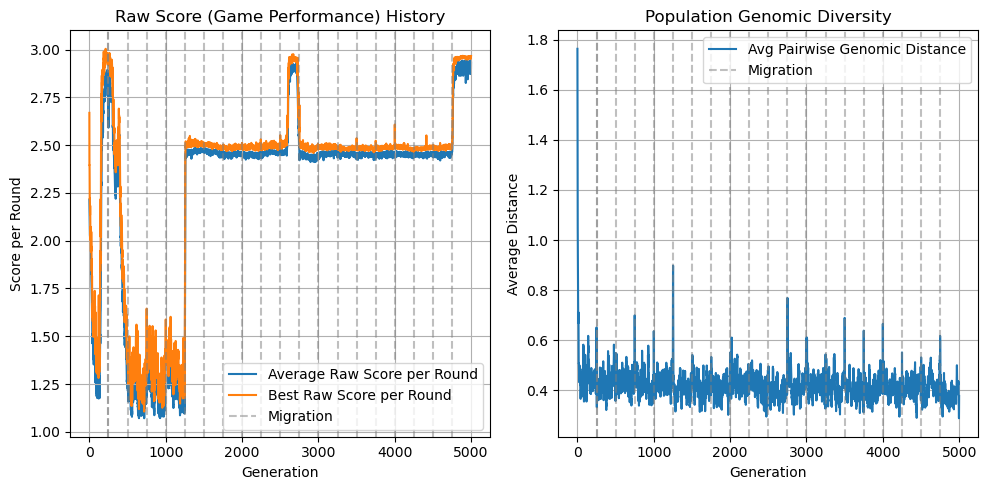

--- Analysis of Final Population on Island 0 ---
Best 2 individuals (by raw score):

Individual 249047: Raw Score: 2.966
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.05 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.02 (Idx 6)
    P(C | My D,D; Opp C,C): 0.44 (Idx 15)
    P(C | My D,D; Opp D,D): 0.96 (Idx 18)

Individual 249046: Raw Score: 2.961
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.05 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.25 (Idx 6)
    P(C | My D,D; Opp C,C): 0.54 (Idx 15)
    P(C | My D,D; Opp D,D): 0.98 (Idx 18)


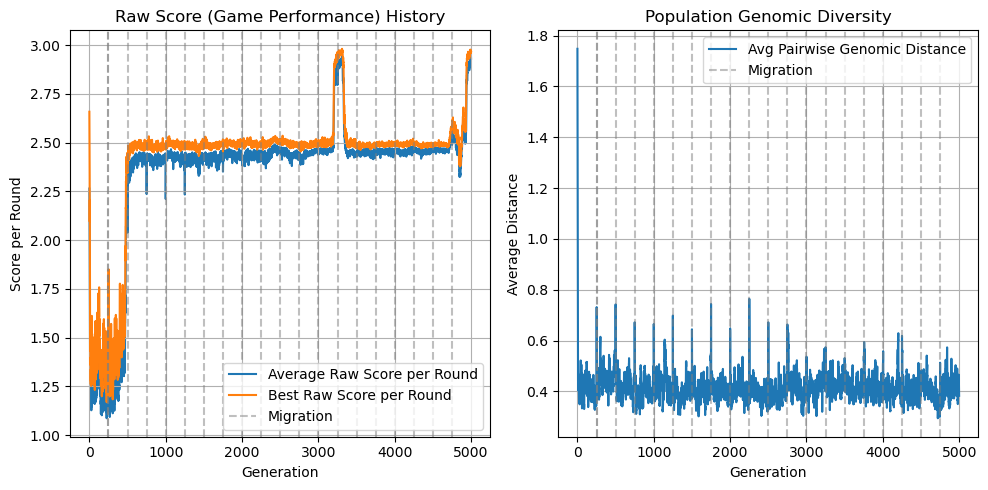

--- Analysis of Final Population on Island 1 ---
Best 2 individuals (by raw score):

Individual 249007: Raw Score: 2.964
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.17 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.07 (Idx 6)
    P(C | My D,D; Opp C,C): 0.76 (Idx 15)
    P(C | My D,D; Opp D,D): 0.26 (Idx 18)

Individual 249017: Raw Score: 2.959
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.19 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.17 (Idx 6)
    P(C | My D,D; Opp C,C): 0.82 (Idx 15)
    P(C | My D,D; Opp D,D): 0.30 (Idx 18)


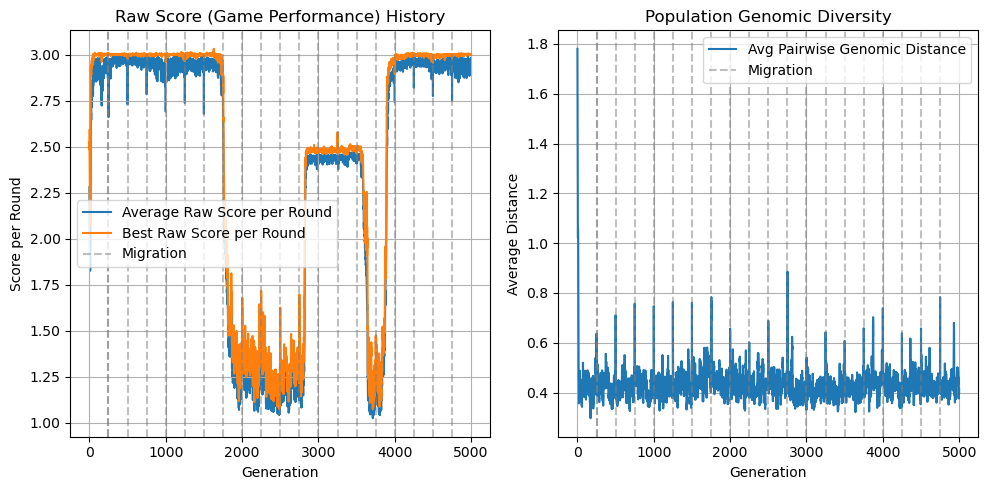

--- Analysis of Final Population on Island 2 ---
Best 2 individuals (by raw score):

Individual 249019: Raw Score: 3.000
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.99 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.44 (Idx 6)
    P(C | My D,D; Opp C,C): 0.28 (Idx 15)
    P(C | My D,D; Opp D,D): 0.55 (Idx 18)

Individual 249027: Raw Score: 3.000
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 1.00 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.35 (Idx 6)
    P(C | My D,D; Opp C,C): 0.33 (Idx 15)
    P(C | My D,D; Opp D,D): 0.53 (Idx 18)


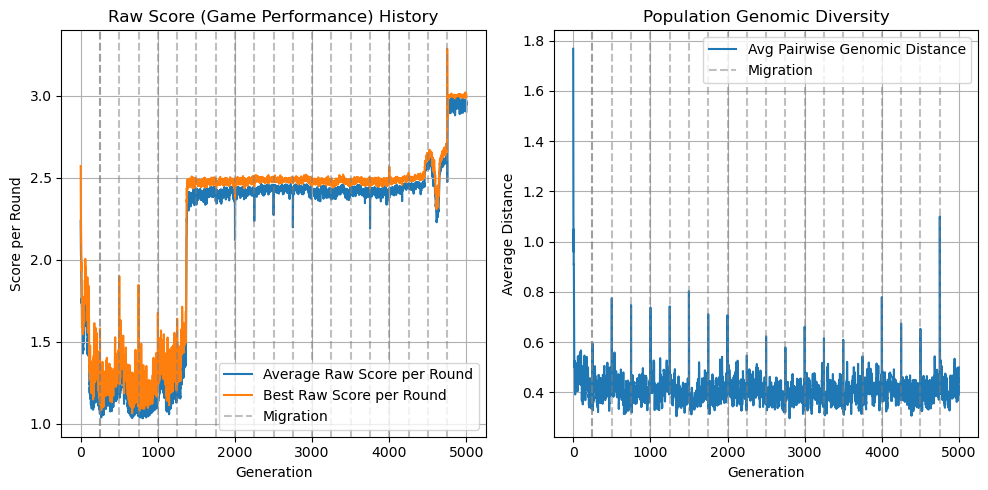

--- Analysis of Final Population on Island 3 ---
Best 2 individuals (by raw score):

Individual 249036: Raw Score: 2.990
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.97 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.34 (Idx 6)
    P(C | My D,D; Opp C,C): 0.25 (Idx 15)
    P(C | My D,D; Opp D,D): 0.39 (Idx 18)

Individual 249043: Raw Score: 2.980
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.96 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.44 (Idx 6)
    P(C | My D,D; Opp C,C): 0.12 (Idx 15)
    P(C | My D,D; Opp D,D): 0.52 (Idx 18)


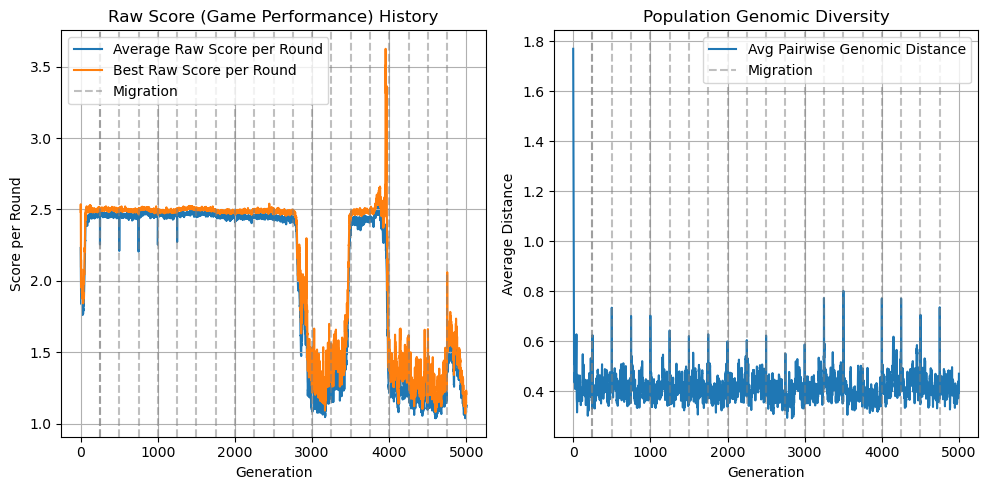

--- Analysis of Final Population on Island 4 ---
Best 2 individuals (by raw score):

Individual 249044: Raw Score: 1.208
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.31 (Idx 0)
    P(C | My C,C; Opp C,C): 0.46 (Idx 3)
    P(C | My C,C; Opp D,D): 0.23 (Idx 6)
    P(C | My D,D; Opp C,C): 0.14 (Idx 15)
    P(C | My D,D; Opp D,D): 0.02 (Idx 18)

Individual 249020: Raw Score: 1.199
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.20 (Idx 0)
    P(C | My C,C; Opp C,C): 0.49 (Idx 3)
    P(C | My C,C; Opp D,D): 0.17 (Idx 6)
    P(C | My D,D; Opp C,C): 0.10 (Idx 15)
    P(C | My D,D; Opp D,D): 0.00 (Idx 18)


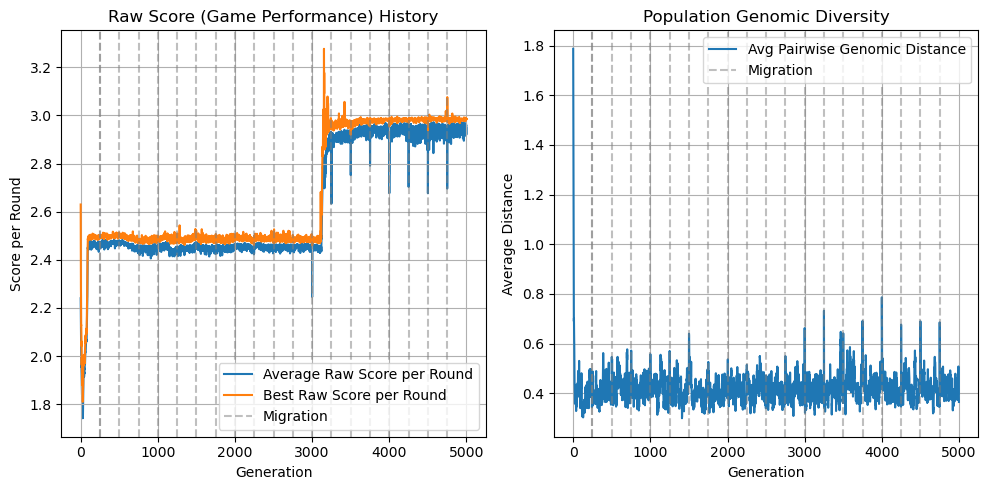

--- Analysis of Final Population on Island 5 ---
Best 2 individuals (by raw score):

Individual 249046: Raw Score: 2.985
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.01 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.26 (Idx 6)
    P(C | My D,D; Opp C,C): 0.07 (Idx 15)
    P(C | My D,D; Opp D,D): 0.59 (Idx 18)

Individual 249001: Raw Score: 2.979
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.00 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.25 (Idx 6)
    P(C | My D,D; Opp C,C): 0.08 (Idx 15)
    P(C | My D,D; Opp D,D): 0.62 (Idx 18)


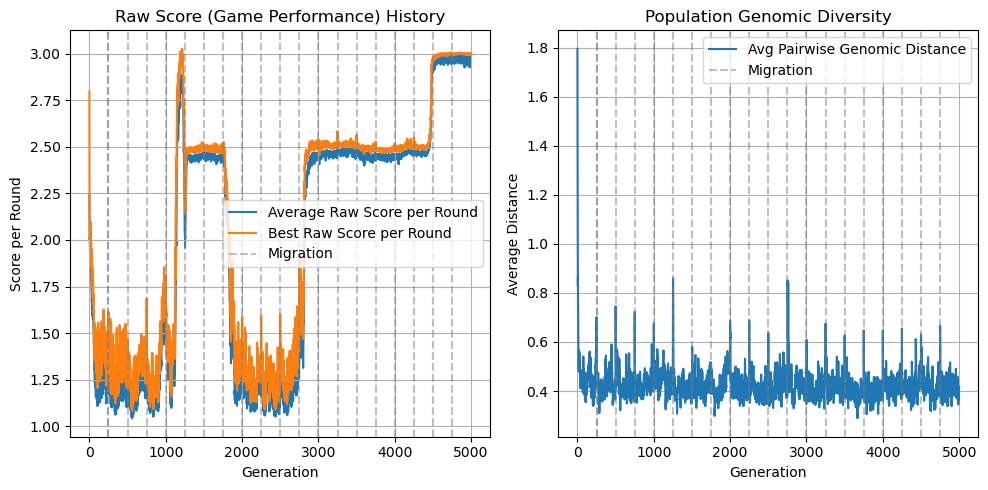

--- Analysis of Final Population on Island 6 ---
Best 2 individuals (by raw score):

Individual 249016: Raw Score: 3.002
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 1.00 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.32 (Idx 6)
    P(C | My D,D; Opp C,C): 0.86 (Idx 15)
    P(C | My D,D; Opp D,D): 0.23 (Idx 18)

Individual 249019: Raw Score: 2.997
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 1.00 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.08 (Idx 6)
    P(C | My D,D; Opp C,C): 1.00 (Idx 15)
    P(C | My D,D; Opp D,D): 0.30 (Idx 18)


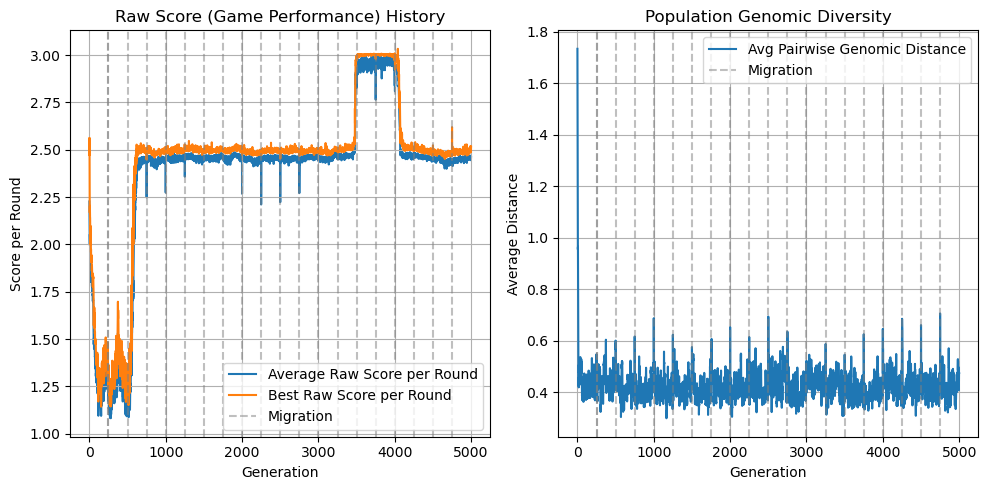

--- Analysis of Final Population on Island 7 ---
Best 2 individuals (by raw score):

Individual 249039: Raw Score: 2.516
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.02 (Idx 0)
    P(C | My C,C; Opp C,C): 0.29 (Idx 3)
    P(C | My C,C; Opp D,D): 0.30 (Idx 6)
    P(C | My D,D; Opp C,C): 0.10 (Idx 15)
    P(C | My D,D; Opp D,D): 0.56 (Idx 18)

Individual 249018: Raw Score: 2.508
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.02 (Idx 0)
    P(C | My C,C; Opp C,C): 0.54 (Idx 3)
    P(C | My C,C; Opp D,D): 0.40 (Idx 6)
    P(C | My D,D; Opp C,C): 0.10 (Idx 15)
    P(C | My D,D; Opp D,D): 0.48 (Idx 18)


In [ ]:
for i in range(N_ISLANDS):
    plot_population(avg_raw_score_histories[i], best_raw_score_histories[i], population_diversity_histories[i], dot_frequency=MIGRATION_FREQUENCY)
    print(f"--- Analysis of Final Population on Island {i} ---")
    analyse_evolved_strategy(populations[i])